In [82]:
___Author___='LumberJack Jyss'

In [83]:
print('Global Optimized LumberJack Equities Method\n°OoO_FOREX_Oo0°\nLumberJack Jyss 5779(c)')

Global Optimized LumberJack Equities Method
°OoO_FOREX_Oo0°
LumberJack Jyss 5779(c)


In [84]:
print('Importing librairies...')
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,roc_curve,confusion_matrix,classification_report
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.utils import to_categorical
%matplotlib inline
print('Librairies imported')

Importing librairies...
Librairies imported


In [85]:
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")
tf.logging.set_verbosity(tf.logging.ERROR)

In [86]:
df_1D = pd.read_csv('20190526 data prepared.csv')
df_1D = df_1D.iloc[:,1:]
#df_1D = df_1D.drop(['Vix','P/C Ratio','Varop_vix','Varhl_vix','Spread'],axis=1)
df_1D = df_1D.dropna()
df_1D.reset_index(inplace=True,drop=True)

plt.figure(figsize=(26,20))
sns.heatmap(df_1D.iloc[:,:-1].corr(),annot=True,cmap='rainbow')
plt.show()

In [87]:
delta = round(df_1D.shape[0])
bloc1 = round(delta*0.8)
bloc2 = delta - bloc1
print("# of periods : ",delta)
print('On 80% - 20% slash : ')
print('Bloc 1 : ',bloc1,' periods (',df_1D.iloc[bloc1,0],')\nBloc 2 :',bloc2,' periods (',df_1D.iloc[bloc2,0],')')
print('First period :',df_1D.iloc[0,0])
print('Last period :',df_1D.iloc[df_1D.shape[0]-1,0])


# of periods :  1208
On 80% - 20% slash : 
Bloc 1 :  966  periods ( 20180618 )
Bloc 2 : 242  periods ( 20150803 )
First period : 20140815
Last period : 20190604


In [88]:
X = df_1D.iloc[:,1:-3]
#X = X.drop(['Peaks','Valley'],axis=1)
#X = X.drop(['75 - RSI','RSI - 25'],axis=1)
y_up = df_1D.iloc[:,-3].values
y_down = df_1D.iloc[:,-2].values


In [89]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
#y_up = scaler.fit_transform(np.array(y_up).reshape(-1,1))
#y_down = scaler.fit_transform(np.array(y_down).reshape(-1,1))

In [90]:
ytrain_up = y_up[:bloc1]
ytest_up = y_up[bloc1:]
ytrain_down = y_down[:bloc1]
ytest_down = y_down[bloc1:]

Xtrain_up =  X[:bloc1,:] #X.loc[:bloc1-1,['Varop_Spy','delta40_45', 'delta45_50']]
Xtrain_down = X[:bloc1,:] #X.loc[:bloc1-1,['Varop_Spy','75 - RSI', 'BBD_Delta_Up']]
Xtest_up =   X[bloc1:,:] #X.loc[bloc1:,['Varop_Spy','delta40_45', 'delta45_50']]
Xtest_down = X[bloc1:,:] #X.loc[bloc1:,['Varop_Spy','75 - RSI', 'BBD_Delta_Up']]

In [91]:
Xtrain_up.shape,Xtrain_down.shape,ytrain_up.shape,ytrain_down.shape

((966, 17), (966, 17), (966,), (966,))

In [92]:
Xtrain_up.shape,ytrain_up.shape,Xtrain_down.shape,ytrain_down.shape,ytest_down.shape,ytest_up.shape,df_1D.iloc[:,1:-3].shape

((966, 17), (966,), (966, 17), (966,), (242,), (242,), (1208, 17))

In [93]:
# fix random seed for reproducibility
seed = 770
np.random.seed(seed)

In [94]:
ytrain_up = ytrain_up.reshape(ytrain_up.shape[0],)
ytrain_down = ytrain_down.reshape(ytrain_down.shape[0],)

Xtrain_up = Xtrain_up.reshape(Xtrain_up.shape[0],Xtrain_up.shape[1])
Xtrain_down = Xtrain_down.reshape(Xtrain_down.shape[0],Xtrain_down.shape[1])

model_up = Sequential()
# Add an input layer 
model_up.add(Dense(50, activation='relu'))
# Add one hidden layer 
model_up.add(Dense(50, activation='relu'))
# Add an output layer 
model_up.add(Dense(1, activation='sigmoid'))

model_down = Sequential()
# Add an input layer 
model_down.add(Dense(50, activation='relu'))
# Add one hidden layer 
model_down.add(Dense(50, activation='relu'))
# Add an output layer 
model_down.add(Dense(1, activation='sigmoid'))

In [95]:
print('Processing move_up')
model_up.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','mse'])
                   
history_up = model_up.fit(Xtrain_up, ytrain_up,epochs=500, batch_size=32, verbose=0)

print('Processing move_down')
model_down.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','mse'])
                   
history_down = model_down.fit(Xtrain_down, ytrain_down,epochs=500, batch_size=32, verbose=0)

print('Computing done')

Processing move_up
Processing move_down
Computing done


In [96]:
train_acc_up = model_up.evaluate(Xtrain_up, ytrain_up,verbose=1)
train_acc_down = model_down.evaluate(Xtrain_down, ytrain_down,verbose=1)
train_acc_up,train_acc_down

966/966 [==============================] - 0s 167us/step


([0.0765547704485208, 0.9668737060041408, 0.02365610080365285],
 [0.10902023772028416, 0.9668737058807357, 0.029556740511123933])

In [97]:
yhat_up = model_up.predict_classes(Xtest_up)
yhat_down = model_down.predict_classes(Xtest_down)

In [98]:
score_up = model_up.evaluate(Xtest_up, ytest_up,verbose=1)
score_down = model_down.evaluate(Xtest_down, ytest_down,verbose=1)
score_up,score_down

242/242 [==============================] - 0s 27us/step


([0.6691698968903093, 0.8264462804991352, 0.12954412757857772],
 [0.765003980252861, 0.8471074360461275, 0.13571266503619753])

In [99]:
confusion_matrix(ytest_up, yhat_up),

(array([[190,  35],
        [  7,  10]]),)

In [100]:
confusion_matrix(ytest_down, yhat_down)

array([[199,  26],
       [ 11,   6]])

In [101]:
predict_up = model_up.predict(Xtest_up)
predict_down = model_down.predict(Xtest_down)

In [102]:

accuracy_up = accuracy_score(ytest_up, yhat_up)
accuracy_down = accuracy_score(ytest_down, yhat_down)

# La précision permet de mesurer la capacité du modèle à refuser résultats non-pertinents : vrais_positifs/(vrais_positifs+faux_positifs)
precision_up = precision_score(ytest_up, yhat_up)  
precision_down = precision_score(ytest_down, yhat_down) 


# Recall : (vrai_positifs/(vrais_positifs+faux_négatifs))
recall_up = recall_score(ytest_up, yhat_up) 
recall_down = recall_score(ytest_down, yhat_down) 


roc_up=roc_auc_score(ytest_up,yhat_up)
roc_down=roc_auc_score(ytest_down,yhat_down)

In [103]:
print('RESULTATS UP\n')
print('Accuracy: %.2f%%' % (accuracy_up * 100.0))
print("Precision: %.2f%% " % (precision_up *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_up * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print("ROC: %.2f%% " % (roc_up *100))
# get probabilities for positive class

print(classification_report(ytest_up, yhat_up))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_up, yhat_up))
print('Matrice de confusion :')
conf_matrix

RESULTATS UP

Accuracy: 82.64%
Precision: 22.22%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 58.82%   => Positifs trouvés par Golem sur tous les positifs existants
ROC: 71.63% 
              precision    recall  f1-score   support

           0       0.96      0.84      0.90       225
           1       0.22      0.59      0.32        17

   micro avg       0.83      0.83      0.83       242
   macro avg       0.59      0.72      0.61       242
weighted avg       0.91      0.83      0.86       242

[[190  35]
 [  7  10]]
Matrice de confusion :


,Vrais_estimés,Faux_estimés
vrais_réels,Vrais_positifs,Faux_négatif
Faux_réels,Faux_positifs,Vrais-négatifs


In [104]:
print('RESULTATS DOWN\n')
print('Accuracy: %.2f%%' % (accuracy_down * 100.0))
print("Precision: %.2f%% " % (precision_down *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_down * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print("ROC: %.2f%% " % (roc_down *100))
# get probabilities for positive class

print(classification_report(ytest_down, yhat_down))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_down, yhat_down))
print('Matrice de confusion :')
conf_matrix

RESULTATS DOWN

Accuracy: 84.71%
Precision: 18.75%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 35.29%   => Positifs trouvés par Golem sur tous les positifs existants
ROC: 61.87% 
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       225
           1       0.19      0.35      0.24        17

   micro avg       0.85      0.85      0.85       242
   macro avg       0.57      0.62      0.58       242
weighted avg       0.89      0.85      0.87       242

[[199  26]
 [ 11   6]]
Matrice de confusion :


,Vrais_estimés,Faux_estimés
vrais_réels,Vrais_positifs,Faux_négatif
Faux_réels,Faux_positifs,Vrais-négatifs


In [105]:
len(df_1D)-(len(df_1D)-241)

241

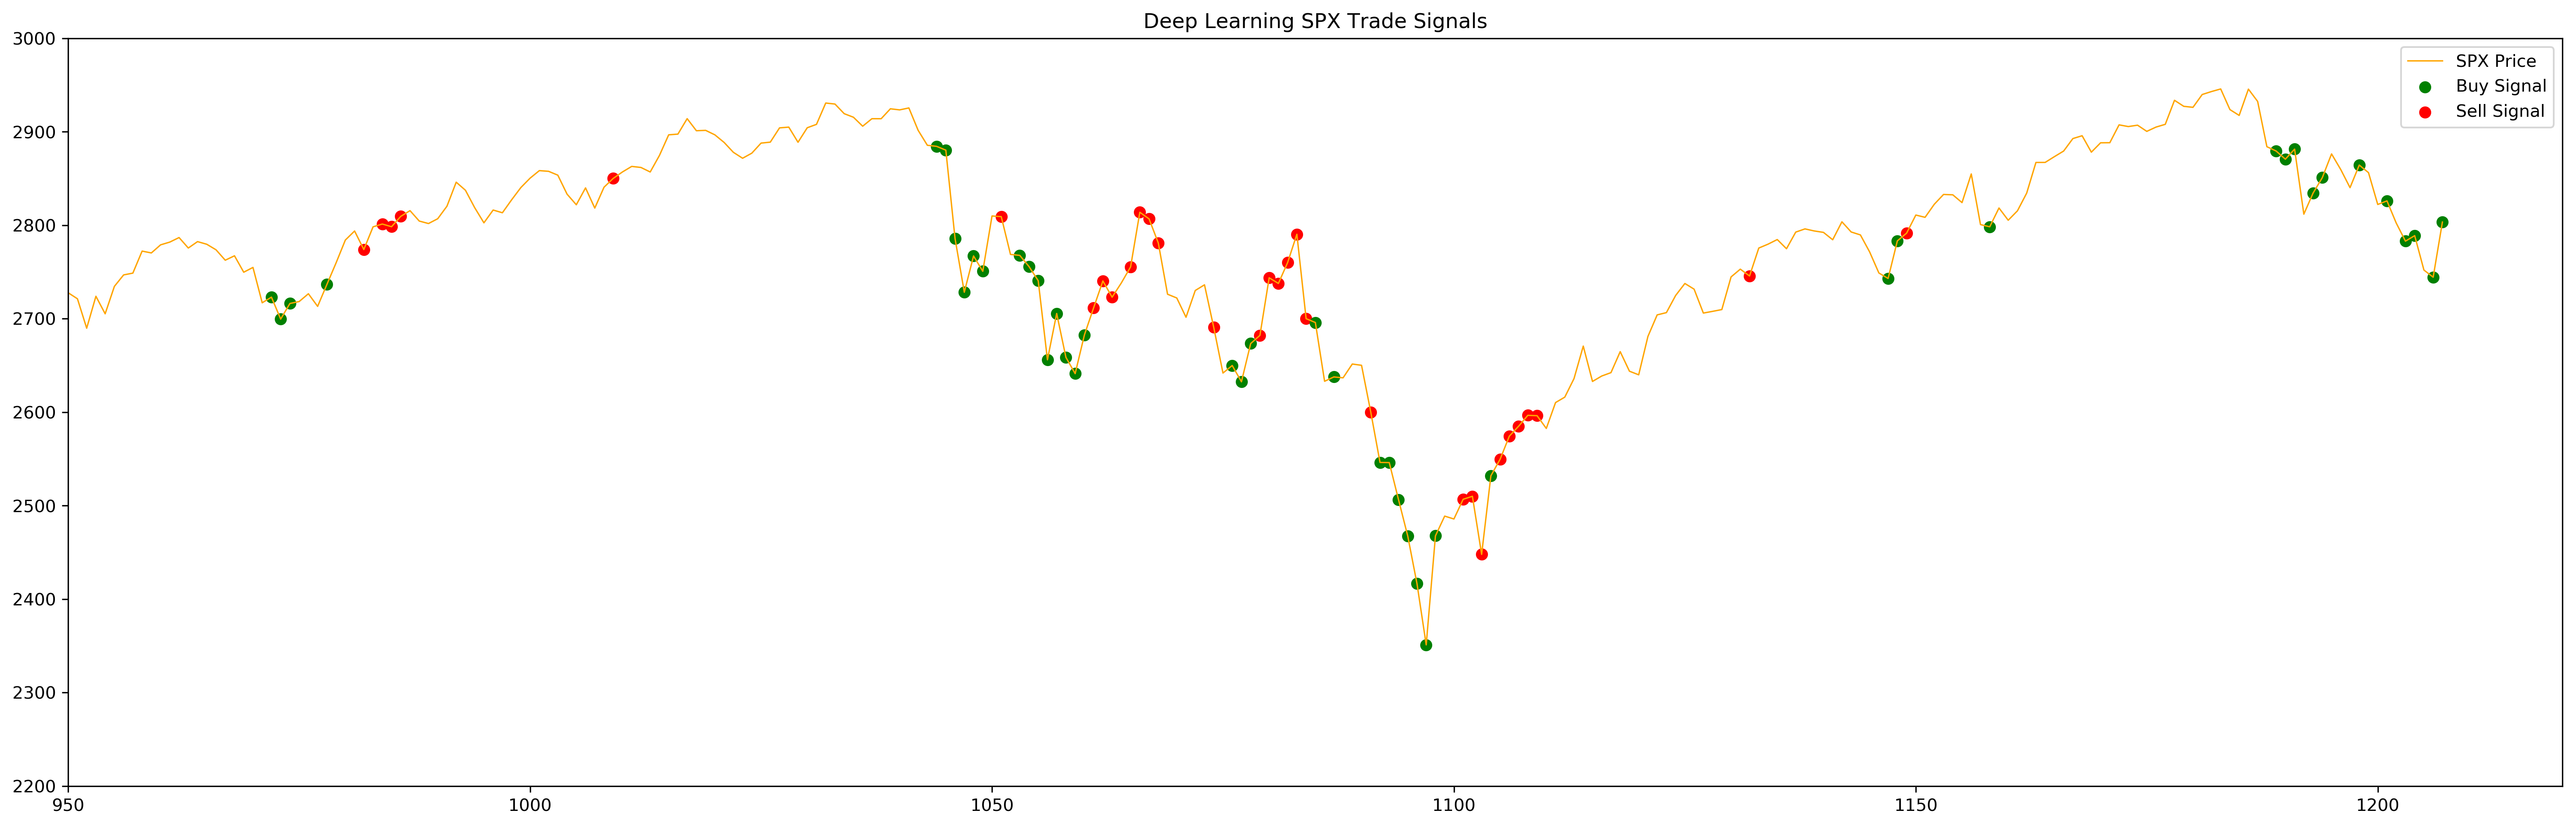

In [106]:
plt.figure(figsize=(26,8),dpi=300)
plt.plot(df_1D['target_value'],color='orange',lw=0.8,label='SPX Price')
plt.xlim(950,1220)
plt.ylim(2200,3000)
plt.scatter(x=0,y=0,c='g',marker='o',label='Buy Signal')
plt.scatter(x=0,y=0,c='r',marker='o',label='Sell Signal')
plt.title('Deep Learning SPX Trade Signals')
a = -1
for i in range(len(df_1D)-241,len(df_1D)):
    a+=1
    if yhat_up[a] == 1:
        plt.scatter(x=df_1D.index[i],y=df_1D.iloc[i,-1],c='g',marker='o')
    elif yhat_down[a] == 1:
        plt.scatter(x=df_1D.index[i],y=df_1D.iloc[i,-1],c='r',marker='o')
plt.legend()

In [107]:
sum(yhat_up),sum(yhat_down),i

(array([45], dtype=int32), array([32], dtype=int32), 1207)

In [108]:
# save the model to disk
filename = 'finalized_model_long.sav'
pickle.dump(model_up, open(filename, 'wb'))
filename = 'finalized_model_short.sav'
pickle.dump(model_down, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)